# Wasserstein Loss and Gradient Penalty

In the course, we discussed the limitations of the binary cross entropy loss (BCE Loss). It can lead to:
* Mode collapse: when the generator is stuck in a single mode of the distribution it is trying to replicate. For example, a generator training on the MNIST dataset would be stuck in generating images of certain digits only, as shown below.

<img src='assets/collapse.png' width=50% />

* Vanishing gradient: it's a common problem with many neural network architectures, but is very common when training GANs. Because the discriminator's task is much easier than the generator's, the discriminator tends to converge faster and reach a high accuracy. The discriminator loss gets close to zero and the gradients become very small, leading to that vanishing gradient problem. 

In this notebook, you will:
* implement the Wasserstein Loss
* implement two types of gradient penalties



## Wasserstein Loss

The Wasserstein GAN paper introduced a new type of loss function: the Wasserstein Distance. 

We are now reshaping the problem GANs are solving: instead of having a loss function that classifies a distribution as being real or not, we have a loss function that tries to minimize the distance between the real and the fake distribution. The difference is subtle but plays a big role in the stability of GANs.

<img src='assets/gradient_replace.png' width=90% />

The discriminator is now called a **critic** because its job is not really to distinguish between real and fake anymore but to maximize the distance between the two distributions. However, we will be using both terms interchangeably for the sake of clarity. 

The Wasserstein loss can be calculated using the formula below:

<center>$\min_{g} \max_{c} E(c(x)) - E(c(g(z)))$</center>

You are now familiar with the minimax function. The main difference with the BCE Loss is the disapperance of the logs!

### First exercise: Implement the Wasserstein Loss

The Wasserstein Loss (W-Loss) is taking the vector of logits outputed by the discriminator as input. In comparison, the BCE Loss was taking the probabilities (logits after a softmax layer) as inputs. The discriminator W-Loss is trying to maximize the mean value of the logits of real images and minize the mean value of the logits of fake images. The generator W-Loss is trying to maximize the mean value of the logits of fake images.


In [8]:
import sys
sys.path.insert(0, '..')
from DCGAN_CIFAR import tests

In [9]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import random
import pickle as pkl

In [10]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
# print("Number of CPU cores:", num_cores)

In [11]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

## Load CIFAR data

In [12]:
from torchvision import datasets, transforms

IMAGE_SIZE = 32
CHANNELS_IMG = 3
# Tensor
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)
# (image - mean) / std
# The parameters mean, std are passed as 0.5, 0.5 in this case. 
# This will normalize the image in the range [-1,1]. 
# For example, the minimum value 0 will be converted to (0-0.5)/0.5=-1, 
# the maximum value of 1 will be converted to (1-0.5)/0.5=1.

cifar_train = datasets.CIFAR10(root='../DCGAN_CIFAR/data/', train=True, download=True, transform=transforms)


BATCH_SIZE=64

# build DataLoaders for CIFAR10 dataset
train_loader = torch.utils.data.DataLoader(dataset=cifar_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_cores, drop_last=True)

Files already downloaded and verified


### Visualize the Data

In [13]:
def revert_img(img):
    return (img*0.5)+0.5

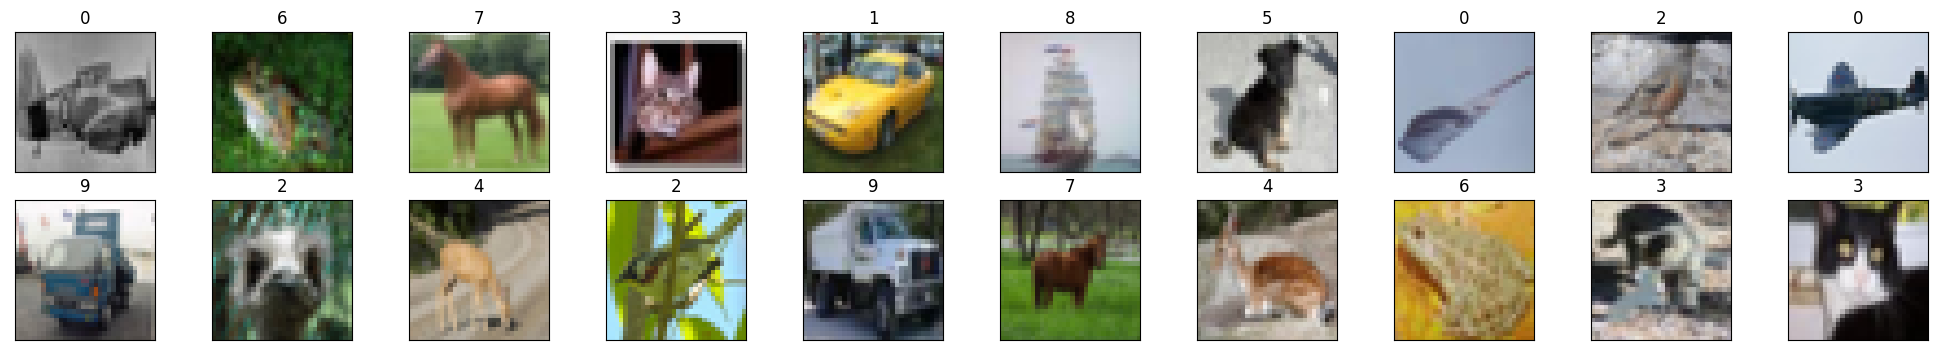

In [14]:
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(revert_img(images[idx]), (1, 2, 0)))
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

## Define the Model

### Critic
* the model is same as the discriminator in DCGAN
* Return the logits instead of sigmoid

In [15]:
class Critic(nn.Module):
    """
    The discriminator model adapted from the DCGAN paper. It should only contains a few layers.
    args:
    - conv_dim: control the number of filters
    """
    def __init__(self, conv_dim: int, channels_img: int = 1):
        super().__init__()
        self.conv_dim = conv_dim
        ####
        # IMPLEMENT HERE
        ####
        self.conv1 = self._block(in_channels=channels_img, out_channels=conv_dim, kernel_size=4, bias=True, batch_norm = False) # 32x32 -> 16x16
        self.conv2 = self._block(in_channels=conv_dim, out_channels=conv_dim*2, kernel_size=4, bias=False) # 16x16 -> 8x8
        self.conv3 = self._block(in_channels=conv_dim*2, out_channels=conv_dim*4, kernel_size=4, bias=False) # 8x8 -> 4x4
        self.conv4 = nn.Conv2d(conv_dim*4, 1, kernel_size=4, stride=2, padding=0, bias=False) # 4x4 -> 1x1
        # self.conv4 = self._block(in_channels=conv_dim*4, out_channels=conv_dim*4*4, kernel_size=4, padding=0, bias=False) # 4x4 -> 1x1
        
        # get rid of any fully connected layer with respect to the DCGAN paper
        # self.flatten = nn.Flatten()
        # self.fc1 = nn.Linear((conv_dim*4*4), conv_dim*4)
        # self.fc2 = nn.Linear((conv_dim*4), 1)
        
    def _block(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int = 2, 
                 padding: int = 1,
                 bias: bool = False,
                 batch_norm: bool = True):
        """
        A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
        args:
        - in_channels: number of channels in the input to the conv layer
        - out_channels: number of filters in the conv layer
        - kernel_size: filter dimension of the conv layer
        - batch_norm: whether to use batch norm or not
        """
        if batch_norm:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                # in the DCGAN paper, they say not to use batchnorm on the first layer of descriminator and last layer of generator
                # however, in dicriminator, the bias will be canceled out in the following layers I think! so in the end, we don't have any bias!?
                nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.LeakyReLU(0.2)
            )
    def forward(self, x):
        ####
        # IMPLEMENT HERE
        ####      
        x = self.conv1(x)
        # print(f"shape at conv1: {x.shape}")
        x = self.conv2(x)
        # print(f"shape at conv2: {x.shape}")
        x = self.conv3(x)
        # print(f"shape at conv3: {x.shape}")
        x = self.conv4(x)
        # print(f"shape at conv4: {x.shape}")
        # x = self.flatten(x)
        # print(f"shape at flatten: {x.shape}")
        # x = self.fc1(x)
        # x = self.fc2(x)
        # print(f"Discriminator fc2: {x.shape}")
        x = x.squeeze()
        return x

### Generaor
* same as DCGAN

In [16]:
class Generator(nn.Module):
    """
    The generator model adapted from DCGAN
    args:
    - latent_dim: dimension of the latent vector 100x1x1
    - conv_dim: control the number of filters in the convtranspose layers
    """
    def __init__(self, latent_dim: int, conv_dim: int = 128, channels_img: int = 1):
        super().__init__()
        ####
        # IMPLEMENT HERE
        ####
        self.conv_dim = conv_dim
        
        # self.flatten = nn.Flatten()
        # self.fc1 = nn.Linear(latent_dim, conv_dim*4*4, bias=False)
        # reshape to (batch_size, conv_dim, 4, 4)
        # self.tconv1 = self._block(in_channels=conv_dim*4*4, out_channels=conv_dim*4, kernel_size=4, stride=2, padding=0, bias=False)
        self.tconv1 = self._block(in_channels=latent_dim, out_channels=conv_dim*4, kernel_size=4, stride=2, padding=0, bias=False)
        self.tconv2 = self._block(in_channels=conv_dim*4, out_channels=conv_dim*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.tconv3 = self._block(in_channels=conv_dim*2, out_channels=conv_dim, kernel_size=4, stride=2, padding=1, bias=False)
        self.tconv4 = self._block(in_channels=conv_dim, out_channels=channels_img, kernel_size=4, stride=2, padding=1, bias=True, batch_norm=False)
    
    
    
    def _block(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int,
                 padding: int,
                 bias: bool = False,
                 batch_norm: bool = True):
        """
        A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
        args:
        - in_channels: number of channels in the input to the conv layer
        - out_channels: number of filters in the conv layer
        - kernel_size: filter dimension of the conv layer
        - stride: stride of the conv layer
        - padding: padding of the conv layer
        - batch_norm: whether to use batch norm or not
        """
        if batch_norm:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.Tanh(),
            )
            
    def forward(self, x):
        ####
        # IMPLEMENT HERE
        ####
        # x = self.flatten(x)
        # x = self.fc1(x)
        # x = x.view(-1, self.conv_dim*4*4, 1, 1)
        # print(f"input {x.shape}")
        x = self.tconv1(x)
        # print(f"shape at conv1: {x.shape}")
        x = self.tconv2(x)
        # print(f"shape at conv2: {x.shape}")
        x = self.tconv3(x)
        # print(f"shape at conv3: {x.shape}")
        x = self.tconv4(x)
        # print(f"shape at conv4: {x.shape}")
        
        return x

### Weight Initialization

* It is with respect to the original DCGAN paper

In [17]:
def weights_init(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

### Model

In [18]:
Z_DIM = 100
D_FEATURE_DIM = 64
G_FEATURE_DIM = 64
C = Critic(D_FEATURE_DIM, CHANNELS_IMG)
G = Generator(Z_DIM, G_FEATURE_DIM, CHANNELS_IMG)

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
C.apply(weights_init);
G.apply(weights_init);
C.to(device);
G.to(device);


In [21]:
print(C)
print(G)

Critic(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
)
Generator(
  (tconv1): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2

### Critic and Generator Losses

In [22]:
def disc_w_loss(real_logits: torch.Tensor, fake_logits: torch.Tensor):
    """
    Wasserstein Discriminator Loss
    
    args:
    - real_logits: vector of logits outputed by the discriminator with a real input image
    - fake_logits: vector of logits outputed by the discriminator with a fake input image 
    return:
    - negative of substraction: 
        the actual algorithm is real-fake but here we add a negative to the whole equation
        that is because the RMSprop is a minimization function while the critic must maximize it.
        so, the minimization of negative is same as maximization
    """
    wloss = real_logits.mean() - fake_logits.mean()
    return -wloss

In [23]:
def disc_g_loss(fake_logits: torch.Tensor):
    """
    Wasserstein Generator Loss
    
    args:
    - fake_logits: vector of logits outputed by the discriminator with a fake input image 
    """

    fake_loss = -fake_logits.mean()
    return fake_loss

### Optimizers

In [24]:
import torch.optim as optim

LEARNING_RATE = 5e-5 
beta1 = 0.5
beta2 = 0.999 # default value


# d_optimizer = optim.Adam(C.parameters(), lr=LEARNING_RATE, betas=(beta1, beta2))  
# g_optimizer = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(beta1, beta2))
c_optimizer = optim.RMSprop(C.parameters(), lr=LEARNING_RATE)
g_optimizer = optim.RMSprop(G.parameters(), lr=LEARNING_RATE)

## Training

In [25]:
from torch.utils.tensorboard import SummaryWriter

In [26]:
# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
fixed_noise = np.random.uniform(-1, 1, size=(32, Z_DIM, 1, 1))
fixed_noise = torch.from_numpy(fixed_noise).float().to(device)
writer_real = SummaryWriter(f"logsW/real")
writer_fake = SummaryWriter(f"logsW/fake")

layout = {
    "All Loss": {
        "loss": ["Multiline", ["c_loss", "g_loss"]],
    },
}
writer_loss = SummaryWriter(f"logsW/loss")
writer_loss.add_custom_scalars(layout)
step = 0


2023-11-06 15:32:43.148207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 15:32:48.951950: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-11-06 15:32:48.952186: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-11-06 15:32:48.952206: W tensorfl

In [27]:
# C.load_state_dict(torch.load("DiscriminatorMSE.pt"))
# G.load_state_dict(torch.load("GeneratorMSE.pt"))

In [28]:
import torchvision
from tqdm import tqdm

NUM_EPOCHS = 20
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01
losses = []
samples = []
C.train()
G.train()


for epoch in tqdm(range(NUM_EPOCHS)):
    # for i in range(n_critic):
    for batch_idx, (real, _) in enumerate(train_loader):
        real = real.to(device)
        
        ### Train Discriminator:
        for _ in range(CRITIC_ITERATIONS):
        
            noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1)
            noise = noise.to(device)
            fake = G(noise)
            real_scores = C(real)
            fake_scores = C(fake.detach())

            # Compute the Wasserstein Distance
            # the actual algorithm is real-fake but here we add a negative to the whole equation
            # that is because the RMSprop is a minimization function while the critic must maximize it.
            # so, the minimization of negative is same as maximization
            c_wasserstein_distance = disc_w_loss(real_scores, fake_scores)

            C.zero_grad()
            # Compute the gradients of the Wasserstein Distance
            # retain_graph=True, because we are going to re-utilize sort of these computations for `fake = G(noise)`
            # when we do update step for the generator
            c_wasserstein_distance.backward(retain_graph=True)
            c_optimizer.step()
            # * Gradient clippling
            for p in C.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP) #underscore means inplace
        
        ### Train Generator: min log(1 - C(G(z))) <-> max log(C(G(z))
        gfake_scores = C(fake)
        g_wasserstein_distance = disc_g_loss(gfake_scores)
        G.zero_grad()
        g_wasserstein_distance.backward()
        g_optimizer.step()
        
        writer_loss.add_scalar("c_loss", c_wasserstein_distance, step)
        writer_loss.add_scalar("g_loss", g_wasserstein_distance, step)
        # # Print losses occasionally and print to tensorboard
        # if batch_idx % 400 == 0:
        #     # append discriminator loss and generator loss
        #     losses.append((c_wasserstein_distance.item(), g_wasserstein_distance.item()))
        #     print(
        #         f"Epoch [{epoch+1}/{NUM_EPOCHS}] Batch {batch_idx}/{len(train_loader)} \
        #           Loss C: {c_wasserstein_distance:.4f}, loss G: {g_wasserstein_distance:.4f}; step: {step}"
        #     )
    # saving samples can be within batch loop inside if batch_idx%100==0, which means every 100 batch save a sample,
    G.eval()
    with torch.no_grad():
        fake = G(fixed_noise)
        # take out (up to) 32 examples
        img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

        writer_real.add_image("Real", img_grid_real, global_step=step)
        writer_fake.add_image("Fake", img_grid_fake, global_step=step)
        # writer_loss.add_scalar('C Loss', c_wasserstein_distance, global_step=step)
        # writer_loss.add_scalar('G Loss', g_wasserstein_distance, global_step=step)
        

        samples.append(fake)
    G.train()
    step += 1


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)



100%|██████████| 20/20 [25:03<00:00, 75.19s/it]


### Show results from tensorboard
* run this in host terminal: `tensorboard --samples_per_plugin images=25 --logdir=logs`
* then open the localhost through the given link
* or run in within notebook as: `!tensorboard --samples_per_plugin images=25 --logdir=logs`
* in case of remote host:
  * forward the localhost port to your local computer using ssh: `ssh -L 16006:localhost:6006 root@myLaptop`

In [ ]:
# !tensorboard --logdir=logs

In [29]:
torch.save(G.state_dict(), 'W_Generator.pt')
torch.save(C.state_dict(), 'W_Discriminator.pt')

### Preview Samples from training

In [ ]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [31]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(10,6), nrows=4, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = revert_img(img.detach())
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(np.transpose((img.to('cpu')), (1, 2, 0)))
    plt.show()

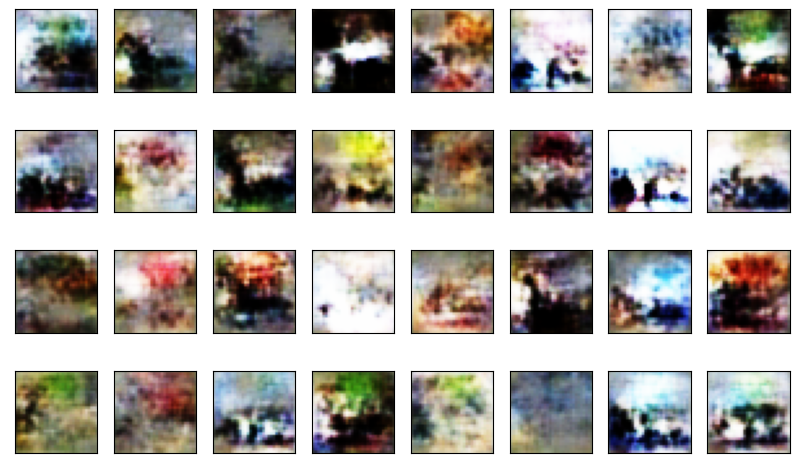

In [32]:
view_samples(-1, samples)

In [ ]:
# # randomly generated, new latent vectors
# sample_size = 800
# rand_z = np.random.uniform(-1, 1, size=(sample_size, Z_DIM, 1, 1))
# rand_z = torch.from_numpy(rand_z).float()

# rand_z = rand_z.to(device)

# G.eval() # eval mode
# # generated samples
# rand_images = G(rand_z)

# # 0 indicates the first set of samples in the passed in list
# # and we only have one batch of samples, here
# view_samples(0, [rand_images])

# # Save generated samples
# with open('WGAN_output.pkl', 'wb') as f:
#     pkl.dump(rand_images, f)

## Gradient penalty

To train a GAN with the Wasserstein Loss, the discriminator (or critic) must be 1-Lipschitz continuous. 

The 1-Lipschitz continuity constraint implies that the norm of the gradient of the function must be below 1. In other words, for a function $f(x)$:

</br>
<center>$|| \frac{df}{dx} || < 1$</center>

Because the W-Loss is not bounded between 0 and 1 like the BCE loss, the above constraint makes sure that the loss does not grow too much. 

In the original paper, the authors enforced this condition by using weight clipping.

## WGAN-GP
Introducing Wasserstein Gan with Gradient Penalty, or WGAN-GP. In this paper, the authors introduce a more robust way to enforce the 1-Lipschitz constaint of the critic: a **gradient penalty term** in the loss function. The new loss function is described below:

<img src='./assets/wgan_gp.png' width=80% />


The gradient penalty is calculated as follows:
* sample a random point $\hat{x}$ between the generated distribution and the real distribution. 
* run this sample through the discriminator and calculate the gradient $\nabla_{\hat{x}} D(\hat{x})$
* calculate the L2 norm of the gradient $|| \nabla_{\hat{x}} D(\hat{x}) ||_{2}$
* remove 1, square the result and calculate the mean $(|| \nabla_{\hat{x}} D(\hat{x}) ||_{2} - 1) ^{2}$

### Second exercise [Optional]: Implement the gradient penalty

In the second exercise of this notebook, you will implement the above gradient penalty. To help you, I have created a dummy critic module.

<br>
<br>
<details>
<summary>
<font size="3" color="black">
<b>Click for tips</b>
</font>
</summary>

* To calculate the gradients, you first have to set the attribute of a tensor `requires_grad` to True.
* You can use the following code to calculate the gradients:
```
torch.autograd.grad(critic(x), x, grad_outputs=torch.ones_like(critic(x)), create_graph=True)[0]
```
</details>

In [199]:
def gradient_penalty(real_sample: torch.Tensor, 
                     fake_sample: torch.Tensor,
                     critic: nn.Module) -> torch.Tensor:
    """
    Gradient penalty of the WGAN-GP model
    args:
    - real_sample: sample from the real dataset
    - fake_sample: generated sample
    
    returns:
    - gradient penalty
    """
    # sample a random point between both distributions
    alpha = torch.rand(real_sample.shape)
    x_hat = alpha * real_sample + (1 - alpha) * fake_sample
    
    # calculate the gradient
    x_hat.requires_grad = True
    pred = critic(x_hat)
    grad = torch.autograd.grad(pred, 
                               x_hat, 
                               grad_outputs=torch.ones_like(pred), 
                               create_graph=True,
                               retain_graph=True)[0]
    
    # calculate the norm and the final penalty
    # norm = torch.norm(grad.view(-1), 2) # generates ONE gp for all images
    norm = torch.norm(grad.view())
    gp = ((norm - 1)**2).mean()    
    return gp

## DRAGAN

The DRAGAN paper offered a different approach to calculate the gradient penalty and enforce the 1-Lipschitz constraint on the critic.

(N. Kodali, J. Abernethy, et al, "*ON CONVERGENCE AND STABILITY OF GANS*", College of Computing Georgia Institute of Technology [Online]Available at: arxiv.org/pdf/1705.07215.pdf \[Accessed 06/30/2022\])

<img src='assets/dragan_gp.png' width=80% />

As you can see, the formula is very similar, especially since the authors use $k = 1$ for their experiments. The main difference with the WGAN-GP gradient penalty is the $\delta$ term, which is a noise term. In their implementation, the authors calculate $X_{p} = X + \delta $ as follows:

<center>
    $X_{p} = X + 0.5 * \sigma({X}) * N$ 
</center>

where $\sigma$ is the standard deviation and $N$ a noise term sampled from the uniform distribution.

The gradient penalty is then calculated as follows:
* sample a random point $\hat{x}$ between the real distribution $X$ and $X_{p}$ . 
* run this sample through the discriminator and calculate the gradient $\nabla_{\hat{x}} D(\hat{x})$
* calculate the L2 norm of the gradient $|| \nabla_{\hat{x}} D(\hat{x}) ||_{2}$
* remove 1, square the result and calculate the mean $(|| \nabla_{\hat{x}} D(\hat{x}) ||_{2} - 1) ^{2}$


### BCE Loss
Interestingly, using this gradient penalty lifts some of the constraint on the BCE Loss and the authors use the above gradient penalty with the vanilla GAN losses (BCE Loss).

### Third exercise  [Optional]: Implement the DRAGAN gradient penalty

In the third exercise of this notebook, you will implement the DRAGAN gradient penalty. This is a one liner difference with the above implementation!

In [202]:
def gradient_penalty_dragan(real_sample: torch.Tensor, critic: nn.Module) -> torch.Tensor:
    """
    Gradient penalty of the WGAN-GP model
    args:
    - real_sample: sample from the real dataset
    
    returns:
    - gradient penalty
    """
    ####
    # IMPLEMENT HERE
    ####
    d = 0.5*torch.std(real_sample)*torch.rand_like(real_sample)
    x_p = real_sample + d
    alpha = torch.rand_like(real_sample)
    x_hat = alpha*real_sample+(1-alpha)*x_p
    x_hat.requires_grad = True
    pred = critic(x_hat)
    grad = torch.autograd.grad(pred, 
                               x_hat, 
                               grad_outputs=torch.ones_like(pred), 
                               create_graph=True)[0]
    
    # calculate the norm and the final penalty
    l2_norm = torch.norm(grad.view(-1), 2)
    gp = torch.mean((l2_norm-1)**2)
    return gp

In [203]:
dragan_gp = gradient_penalty_dragan(real_sample, critic)
dragan_gp

tensor(12203.4219, grad_fn=<MeanBackward0>)

# WARNING

The gradient penalty terms penalize each input to the critic individually. Therefore, the critic should map a single input to a single output. However, we use some layers in the discriminator that remove this property: the BatchNormalization layers. 

Keep this in mind if you decide to use the gradient penalty in your project! 